In [1]:
import os
%pwd

'/mnt/cb03386d-9344-47b1-82f9-868fbb64b4ae/python_projects/Churn_Customer_Lifetime_Value_prediction/research'

In [2]:
os.chdir("../")
%pwd

'/mnt/cb03386d-9344-47b1-82f9-868fbb64b4ae/python_projects/Churn_Customer_Lifetime_Value_prediction'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set_palette("viridis")

##### 1. Load the data
##### Display first few rows to confirm data loading

In [4]:
df = pd.read_excel(
    'artifacts/data_ingestion/sample_data__technical_assessment.xlsx',
    engine='openpyxl'
)

df.head()

,activity_month,account_id,brand_id,reg_date,ftd_date,qp_date,ben_login_id,tracker_id,player_reg_product,total_deposit,total_handle,total_ngr
0,2023-11-01,185196607,PA,2023-11-21,2023-11-21,NaT,BCUSA22L,7102592,BETTING,10.0,210.0,13.18
1,2023-11-01,154497623,AZ,2022-10-28,2022-10-28,2022-10-28,actionnetwork,7039239,BETTING,0.0,5.0,4.00
2,2023-11-01,153249011,MI,2022-08-18,2023-12-21,NaT,starsportsmx,7049874,CASINO,0.0,0.0,0.00
3,2023-11-01,184718245,OH,2023-11-13,2023-11-13,2023-11-13,actionnetwork,7106987,BETTING,10.0,210.0,138.98
4,2023-11-01,183573211,OH,2023-11-06,2023-11-06,2023-11-06,BCUSA22NP,7106983,BETTING,10.0,210.0,-320.22


##### 2. Check for nulls, data types, and date ranges

In [5]:
print(df.info())
print('____________________________________________________________________________________________')
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   activity_month      52500 non-null  datetime64[ns]
 1   account_id          52500 non-null  int64         
 2   brand_id            52500 non-null  object        
 3   reg_date            52500 non-null  datetime64[ns]
 4   ftd_date            45238 non-null  datetime64[ns]
 5   qp_date             31263 non-null  datetime64[ns]
 6   ben_login_id        52500 non-null  object        
 7   tracker_id          52500 non-null  int64         
 8   player_reg_product  52500 non-null  object        
 9   total_deposit       52500 non-null  float64       
 10  total_handle        52338 non-null  float64       
 11  total_ngr           52500 non-null  float64       
dtypes: datetime64[ns](4), float64(3), int64(2), object(3)
memory usage: 4.8+ MB
None
_____________________

##### How to handle missing data
###### For ftd_date missing data, we will assume that player deposited on registration date.
###### qp_date missing data we will impute with ftd_tate.
###### If we assume missing total_handle means zero wagering for that month it is safe to impute missing values with 0.0

In [ ]:
df['ftd_date'] = df['ftd_date'].fillna(df['reg_date'])
df['qp_date'] = df['qp_date'].fillna(df['ftd_date'])
df['total_handle'] = df['total_handle'].fillna(0.0)

df.isnull().sum()

##### Convert date columns to datetime

In [6]:
date_columns = ['activity_month', 'reg_date', 'ftd_date', 'qp_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

##### Check date ranges

In [7]:
for col in date_columns:
    print(f"{col}: {df[col].min()} to {df[col].max()}")

activity_month: 2022-09-01 00:00:00 to 2024-05-01 00:00:00
reg_date: 2022-01-04 00:00:00 to 2024-05-31 00:00:00
ftd_date: 2020-03-08 00:00:00 to 2024-06-06 00:00:00
qp_date: 2022-01-09 00:00:00 to 2024-06-09 00:00:00


##### Check unique values in categorical columns

In [8]:
categorical_columns = ['brand_id', 'ben_login_id', 'tracker_id', 'player_reg_product']
print("\nUnique Values in Categorical Columns:")
for col in categorical_columns:
    print(f"{col}: {df[col].nunique()} unique values")


Unique Values in Categorical Columns:
brand_id: 29 unique values
ben_login_id: 7 unique values
tracker_id: 960 unique values
player_reg_product: 5 unique values


##### 3. Understand key metrics: deposits, handle, NGR distributions

In [9]:
key_metrics = ['total_deposit', 'total_handle', 'total_ngr']

print("\nSummary Statistics for Key Metrics:")
print(df[key_metrics].describe())


Summary Statistics for Key Metrics:
       total_deposit  total_handle      total_ngr
count   52500.000000  5.233800e+04   52500.000000
mean      262.379566  1.552656e+03      36.718138
std      3057.920409  2.737943e+04    1037.177318
min         0.000000  0.000000e+00 -116450.000000
25%         0.000000  0.000000e+00      -0.080000
50%         0.000000  3.000000e+01       0.000000
75%        40.000000  2.200000e+02      29.780000
max    437952.000000  4.769780e+06   59168.400000


##### Plot distributions

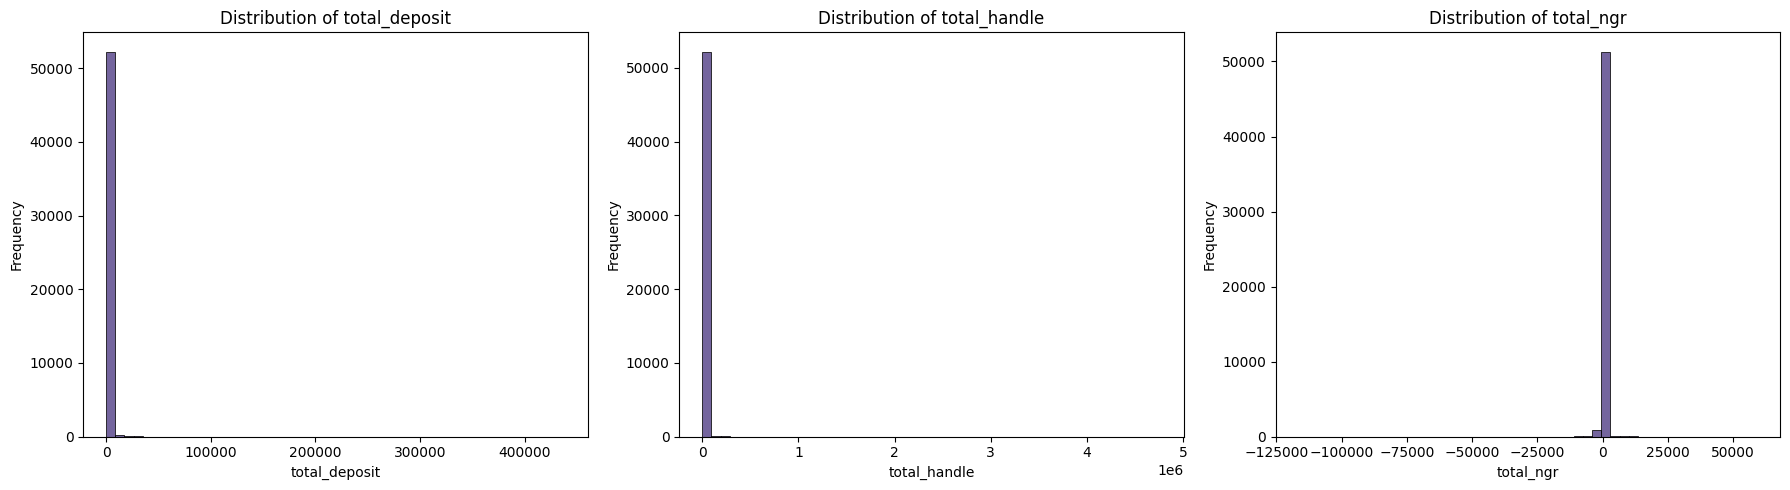

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(key_metrics):
    sns.histplot(df[metric], bins=50, ax=axes[i])
    axes[i].set_title(f'Distribution of {metric}')
    axes[i].set_xlabel(metric)
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()
# plt.savefig('key_metrics_distributions.png')
plt.close()

##### Box plots to visualize spread and potential outliers

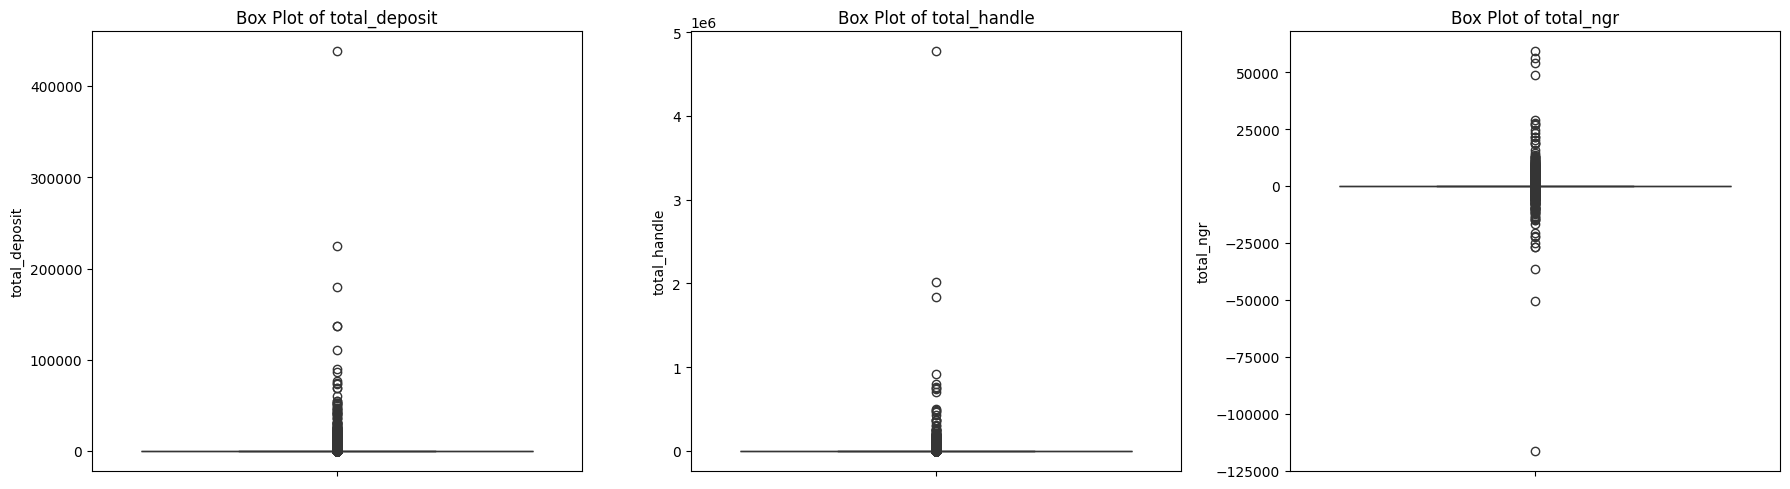

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(key_metrics):
    sns.boxplot(y=df[metric], ax=axes[i])
    axes[i].set_title(f'Box Plot of {metric}')
    axes[i].set_ylabel(metric)
plt.tight_layout()
plt.show()
# plt.savefig('key_metrics_boxplots.png')
plt.close()

##### 4. Detect outliers using IQR method

In [12]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers

print("\nOutliers Detection:")
for metric in key_metrics:
    outliers = detect_outliers(df, metric)
    print(f"\nOutliers in {metric}: {len(outliers)}")
    if not outliers.empty:
        print(outliers.head())


Outliers Detection:

Outliers in total_deposit: 8247
34      259.54
38     1300.00
76     1729.54
95      517.81
125     105.00
Name: total_deposit, dtype: float64

Outliers in total_handle: 7881
8      1188.58
21     1614.04
24      624.00
34      938.27
38    32569.90
Name: total_handle, dtype: float64

Outliers in total_ngr: 13933
3     138.98
4    -320.22
7     136.00
8     261.74
10    148.98
Name: total_ngr, dtype: float64


##### 6. Create derived column: months_active
##### Calculate months_active as the difference between last activity_month and reg_date

In [13]:
df['months_active'] = ((df['activity_month'].dt.year - df['reg_date'].dt.year) * 12 +
                      (df['activity_month'].dt.month - df['reg_date'].dt.month) + 1)

df.head()

,activity_month,account_id,brand_id,reg_date,ftd_date,qp_date,ben_login_id,tracker_id,player_reg_product,total_deposit,total_handle,total_ngr,months_active
0,2023-11-01,185196607,PA,2023-11-21,2023-11-21,NaT,BCUSA22L,7102592,BETTING,10.0,210.0,13.18,1
1,2023-11-01,154497623,AZ,2022-10-28,2022-10-28,2022-10-28,actionnetwork,7039239,BETTING,0.0,5.0,4.00,14
2,2023-11-01,153249011,MI,2022-08-18,2023-12-21,NaT,starsportsmx,7049874,CASINO,0.0,0.0,0.00,16
3,2023-11-01,184718245,OH,2023-11-13,2023-11-13,2023-11-13,actionnetwork,7106987,BETTING,10.0,210.0,138.98,1
4,2023-11-01,183573211,OH,2023-11-06,2023-11-06,2023-11-06,BCUSA22NP,7106983,BETTING,10.0,210.0,-320.22,1


##### Handle negative or zero months_active (possible data errors)

In [14]:
df.loc[df['months_active'] <= 0, 'months_active'] = 1  # Assume at least 1 month active
print("\nSummary of months_active:")
print(df['months_active'].describe())


Summary of months_active:
count    52500.000000
mean         5.848857
std          5.807980
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max         27.000000
Name: months_active, dtype: float64


##### Plot distribution of months_active

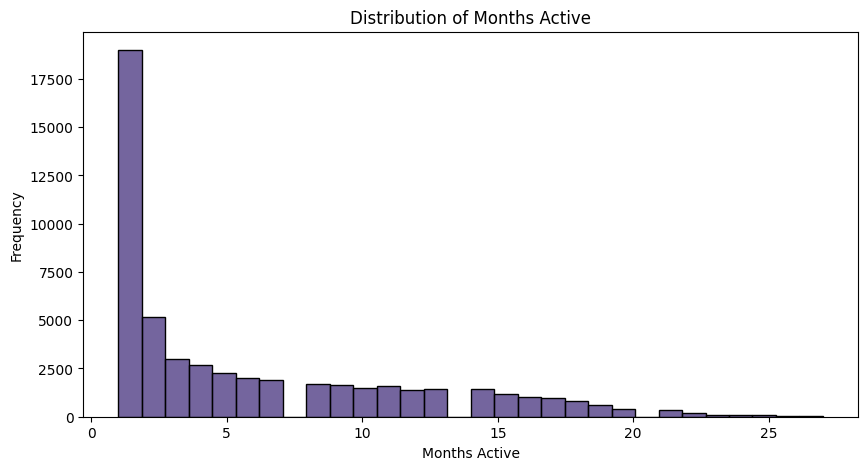

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(df['months_active'], bins=30)
plt.title('Distribution of Months Active')
plt.xlabel('Months Active')
plt.ylabel('Frequency')
plt.show()
# plt.savefig('months_active_distribution.png')
plt.close()

##### Additional Analysis: Correlation between key metrics

In [16]:
correlation_matrix = df[key_metrics].corr()
print(correlation_matrix)

               total_deposit  total_handle  total_ngr
total_deposit       1.000000      0.813418   0.127089
total_handle        0.813418      1.000000  -0.011557
total_ngr           0.127089     -0.011557   1.000000


##### Heatmap of correlations

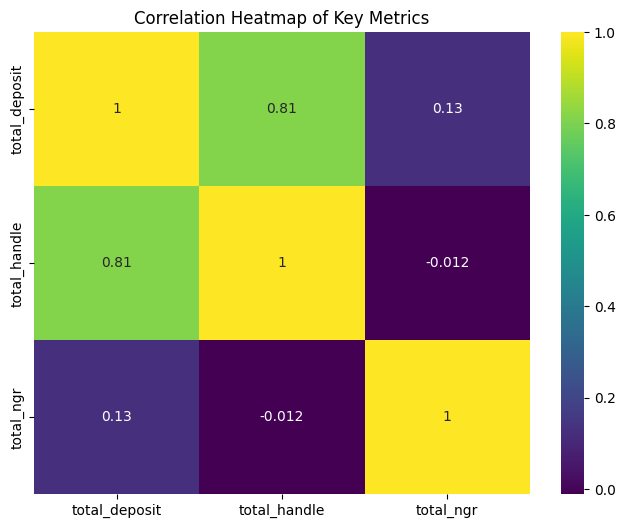

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.title('Correlation Heatmap of Key Metrics')
plt.show()
# plt.savefig('correlation_heatmap.png')
plt.close()

##### Dealing with skewed financial data
##### Log-transform financial columns to reduce skew (adding 1 to handle zeroes)

In [19]:
for col in ['total_deposit', 'total_handle', 'total_ngr']:
    df[f'log_{col}'] = np.log1p(df[col])

/mnt/cb03386d-9344-47b1-82f9-868fbb64b4ae/python_projects/Churn_Customer_Lifetime_Value_prediction/env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/cb03386d-9344-47b1-82f9-868fbb64b4ae/python_projects/Churn_Customer_Lifetime_Value_prediction/env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:
df.head()

,activity_month,account_id,brand_id,reg_date,ftd_date,qp_date,ben_login_id,tracker_id,player_reg_product,total_deposit,total_handle,total_ngr,months_active,log_total_deposit,log_total_handle,log_total_ngr
0,2023-11-01,185196607,PA,2023-11-21,2023-11-21,NaT,BCUSA22L,7102592,BETTING,10.0,210.0,13.18,1,2.397895,5.351858,2.651833
1,2023-11-01,154497623,AZ,2022-10-28,2022-10-28,2022-10-28,actionnetwork,7039239,BETTING,0.0,5.0,4.00,14,0.000000,1.791759,1.609438
2,2023-11-01,153249011,MI,2022-08-18,2023-12-21,NaT,starsportsmx,7049874,CASINO,0.0,0.0,0.00,16,0.000000,0.000000,0.000000
3,2023-11-01,184718245,OH,2023-11-13,2023-11-13,2023-11-13,actionnetwork,7106987,BETTING,10.0,210.0,138.98,1,2.397895,5.351858,4.941500
4,2023-11-01,183573211,OH,2023-11-06,2023-11-06,2023-11-06,BCUSA22NP,7106983,BETTING,10.0,210.0,-320.22,1,2.397895,5.351858,NaN


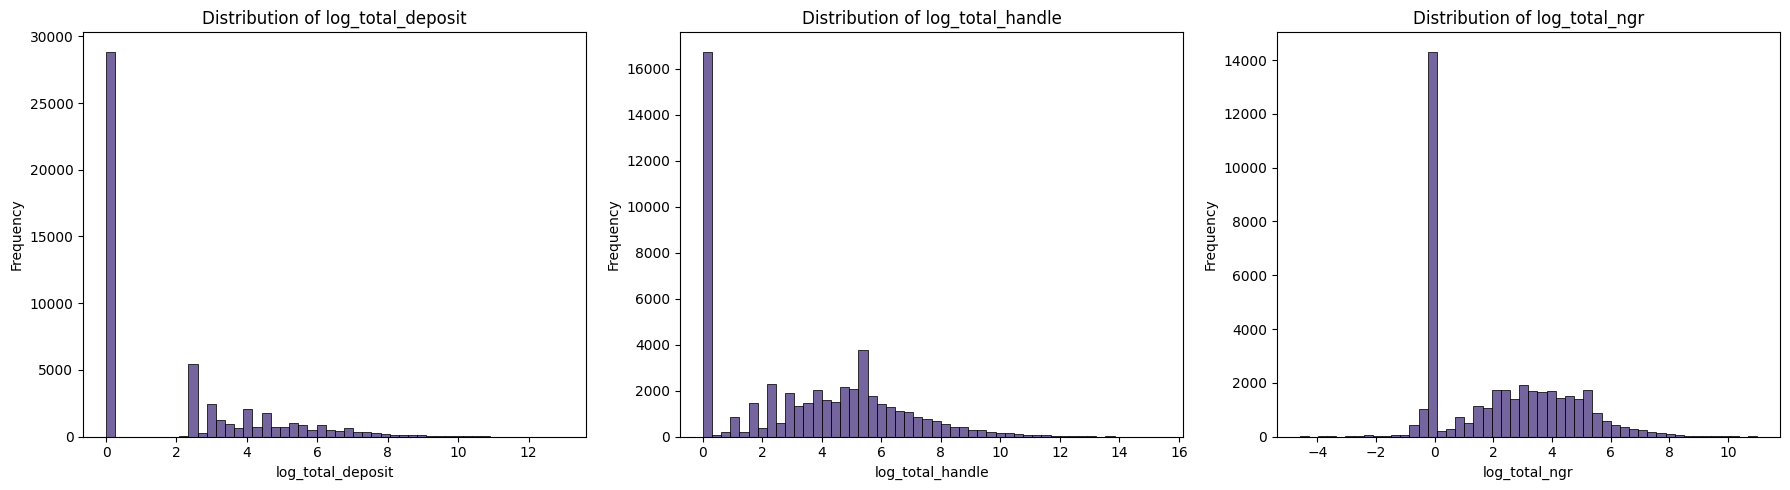

In [21]:
log_key_metrics = ['log_total_deposit', 'log_total_handle', 'log_total_ngr']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(log_key_metrics):
    sns.histplot(df[metric], bins=50, ax=axes[i])
    axes[i].set_title(f'Distribution of {metric}')
    axes[i].set_xlabel(metric)
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()
# plt.savefig('key_metrics_distributions.png')
plt.close()